In [22]:
from tqdm.notebook import tqdm
import requests
import ssl
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import time
ssl._create_default_https_context = ssl._create_unverified_context

def notable_amount(x):
    return 'Lac' in x or 'Cr' in x or 'K' in x

def to_numeric_amount(x):
    unit_multiplier = {'K': 1e3, "Lac": 1e5, "Cr": 1e7}
    for u, v in unit_multiplier.items():
        if u in x:
            return round(float(x.split()[1]) * v)

def anomaly_to_standard(df):
    df.loc[df['City'].str.contains("-"), "City"] = 'Multi-City'
    df.loc[df['City'].str.contains("-"), "State"] = 'Maharashtra'
    return df
    
def readable_time_format(x):
    minute = x // 60
    second = x % 60
    if second == 0 or second == 1:
        if minute == 0 or minute == 1:
            return f'{minute} Minute {second} Second'
        else:
            return f'{minute} Minutes {second} Second'
    else:
        if minute == 0 or minute == 1:
            return f'{minute} Minute {second} Seconds'
        else:
            return f'{minute} Minutes {second} Seconds'
        
def page_links(url, end_page_number):
    if end_page_number == 1:
        return [url]
    else:
        return [url.replace("1", str(i), 1) for i in range(1, end_page_number + 1)]

def extract_data(tab):
    try:
        link = tab.find('a')
        if link:
            link_title = link.get('title')
            link_url = link['href']
        else:
            link_title = "Unknown"
            link_url = "Unknown"

        date_element = tab.find_all('span', class_='truncate textHeading')[0]
        amount_element = tab.find_all('span', class_='truncate textHeading')[1]
        location_element = tab.find('span', class_='truncate relative tender-locations')
        stage_element = tab.find('span', class_='info-chip-title m-r-15')
        categories_element = tab.find('span', class_='text-box')

        # Use a function to extract text safely, providing a default value if the element is not found.
        def get_text(element, default="Unknown"):
            return element.get_text() if element else default

        return {
            "Title": link_title,
            "URL": link_url,
            "Contract Date": get_text(date_element),
            "Contract Amount": get_text(amount_element),
            "Location": get_text(location_element),
            "Stage": get_text(stage_element),
            "Categories": get_text(categories_element)
            }
        
    except Exception as e:
        # Handle any exceptions that may occur during parsing
        print(f"An error occurred: {e}")
        return None

def preprocess_and_clean(df):
    df['Tender_ID'] = df['Title'].str.split(" - ").str[0]
    df['Stage'] = df['Stage'].str.split(': ').str[1].str.strip()
    df['Stage'].fillna("Unknown", inplace=True)
    df.loc[df['Stage'].str.contains('AOC'), 'Stage'] = 'AOC'
    df['Description'] = df['Title'].str.split(" - ").str[1]
    df['City'] = df['Location'].str.split(',').str[0]
    df['State'] = df['Location'].str.split(',').str[1]
    df['Authority'] = df['URL'].str.split("/").str[5].str.replace("-", " ").str.title()
    df.drop(columns=['Title', 'Location'], axis=1, inplace=True)
    return df

def website_to_df(url, end_page_number):
    url = url.replace("?", "/tender-page-1?", 1)
    start = time.time()
    df = pd.DataFrame()
    end_page_number = int(end_page_number)
    
    tab_links = []
    for link in page_links(url, end_page_number):
        response = requests.get(link)
        soup = BeautifulSoup(response.content, 'html.parser')
        tab_containers = soup.find_all('div', class_='block card clearfix')
        tab_links.extend(tab_containers)
        
    data_list = [extract_data(tab) for tab in tqdm (tab_links, ncols=800)
                 if (extract_data(tab), time.sleep(0.3))]
    df = pd.DataFrame(data_list)
    df = preprocess_and_clean(df)
    df = df.loc[df['Contract Amount'].apply(notable_amount)].reset_index(drop=True)
    df['Contract Amount'] = df['Contract Amount'].str.strip()
    df['numeric_amount'] = df['Contract Amount'].apply(to_numeric_amount)
    desired_cols = ['Description', 'Authority', 'Stage', 'Contract Date', 'Contract Amount',
                    'City', 'URL', 'Tender_ID', 'State', 'Categories', 'numeric_amount']
    df = df[desired_cols]
    df = anomaly_to_standard(df)
    end = time.time()
    time_elapsed = round(end - start)
    return df, time_elapsed

url = input('Paste the copied Link Address of the Page:')
print()
end_page_number = input("Enter the number of pages you want:")
print()
df, time_elapsed = website_to_df(url, end_page_number)
print(readable_time_format(time_elapsed))
# filename = f"NGP & AMR, {df.shape[0]} Tenders.xlsx"
# df.to_excel(filename, index=False)
# df

Paste the copied Link Address of the Page: https://bidassist.com/tender-results/all-tenders/active?sort=RELEVANCE:DESC&pageNumber=0&pageSize=10&tenderType=ACTIVE&tenderEntity=TENDER_RESULT&year=2023&filter=CATEGORY:Bridge%20Construction%7CBuilding%20Construction%7CCivil%20Works%20Others%7CConstruction%20Material%7CDrainage%20Work%7CHighway%20Construction%7CIrrigation%20Work%7CPipe%20Line%20Project%7CRoad%20Construction%7CWater%20Storage%20And%20Supply&filter=LOCATION_STRING:Maharashtra&filter=DISTRICT_LOCATION:Amravati%7CNagpur&removeUnavailableTenderAmountCards=false&removeUnavailableEmdCards=false


Enter the number of pages you want: 1000


  0%|                                                                                                         …

76 Minutes 1 Second


In [51]:
def unique_work_categories():
    k = []
    for i in list(df['Categories']):
        for j in list(i.split(',')):
            k.append(j.strip())
    return list(set(k))
# unique_work_categories()

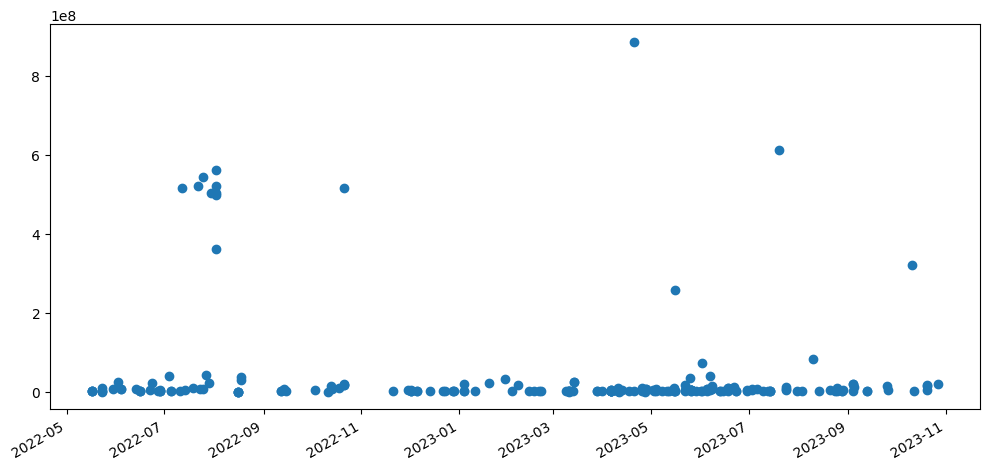

In [76]:
df['Contract Date'] = pd.to_datetime(df['Contract Date'])
plt.figure(figsize=(12,5))
data = df[df['Authority'].str.contains('Water')].sort_values(by='Contract Date')
plt.scatter(data=data, x='Contract Date', y='numeric_amount')
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

In [7]:
z = 10
for j in range(1, z):
    print('<' * j, "}"*j)
    cons = "<"*j
    plus = '}'*j
    if j == z-1:
        print(cons+'<', plus+'}')
        for i in range(z):
            print(cons[i:], plus[i:])

< }
<< }}
<<< }}}
<<<< }}}}
<<<<< }}}}}
<<<<<< }}}}}}
<<<<<<< }}}}}}}
<<<<<<<< }}}}}}}}
<<<<<<<<< }}}}}}}}}
<<<<<<<<<< }}}}}}}}}}
<<<<<<<<< }}}}}}}}}
<<<<<<<< }}}}}}}}
<<<<<<< }}}}}}}
<<<<<< }}}}}}
<<<<< }}}}}
<<<< }}}}
<<< }}}
<< }}
< }
 
